# 내 데이터셋으로 YOLO 모델 학습

## 1. 모델 불러오기( 전이학습 x)

In [1]:
import os
import cv2
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt

print("Pytorch:", torch.__version__)  # 토치 버전 확인
print("CUDA available:", torch.cuda.is_available())  # GPU 사용 여부

Pytorch: 2.8.0+cu126
CUDA available: True


여기서 데이터셋을 만들어야 하는데, 테스트용으로 roboflow로 진행

- 직접 데이터셋을 만드는 것이 아닌 일단 기본적으로 약인지 아닌지 구분을 먼저 하기 위한 테스트용으로 작성
- 잘 된다면, 다운로드 받은 경구약제 이미지와 라벨링 데이터를 활용하여 학습 진행. 어떻게 진행할 지 상의

# Roboflow 에서 데이터 불러오기

In [ ]:
# roboflow 에서 붙여왔던 코드
from roboflow import Roboflow
from dotenv import load_dotenv

# .env 파일 읽어오기
load_dotenv()

# 환경변수 가져오기
api_key = os.getenv("ROBOFLOW_API_KEY")

rf = Roboflow(api_key=api_key)  # 본인 계정 API 키 넣기
project = rf.workspace("my-first-project-e1w1v").project(
    "drug-detection-f6hkt-xdzbz"
)  # 앞은 내 전체 프로젝트 / 뒤에는 그 안의 세부 폴더(이건 copy project id 해서 가져오면 됨)
version = project.version(1)
dataset = version.download(
    "yolov11"
)  # location= 내가 지정하고 싶은 폴더로 .yaml 파일을 저장(dataset이 다 저장되는거긴함)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to drug-detection-1 in yolov11:: 100%|██████████| 512/512 [00:00<00:00, 910.96it/s] 


In [3]:
# YOLO11n 모델 구조만 불러오기(COCO 사전학습 X)
# 추후 학습 시킬 데이터셋은 data.yaml 에서 지정할 예정
model = YOLO("yolo11n.yaml")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 2. 데이터셋 경로 설정

In [ ]:
# 3. 데이터셋 경로 설정 (추후 수정 필요)
# Roboflow에서 다운로드 받거나, AI Hub 항생제 데이터셋 변환 후
# 아래 data.yaml 경로만 수정해주면 됨.

DATA_YAML_PATH = "C:/project_sep/modeling/YOLO/yolo11n/drug-detection-1/data.yaml"  # 추후 변경(경구제약 이미지로)

print("Data config path:", DATA_YAML_PATH)

Data config path: C:/project_sep/modeling/YOLO/yolo11n/drug-detection-1/data.yaml


## 3. 학습

In [ ]:
results = model.train(
    data=DATA_YAML_PATH, epochs=50, batch=8, imgsz=640  # baseline이라 짧게함
)

Ultralytics 8.3.199  Python-3.10.18 torch-2.8.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:/project_sep/modeling/YOLO/yolo11n/drug-detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train33, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla

In [17]:
# Validation (추후 실행)

metrics = model.val()
print(metrics)  # Precision, Recall, mAP

Ultralytics 8.3.199  Python-3.10.18 torch-2.8.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2426.5958.0 MB/s, size: 578.4 KB)
val: Scanning C:\project_sep\modeling\YOLO\yolo11n\drug-detection-1\valid\labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 21/21  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.2it/s 2.5s0.4ss
                   all         21         61      0.982          1      0.994      0.828
Speed: 2.2ms preprocess, 15.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to C:\YOLOproject\runs\detect\train332
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002A53

## 4. 테스트

In [20]:
input_dir = (
    "C:/project_sep/modeling/YOLO/yolo11n/images/original"  # 내가 찍은 알약 폴더
)
output_dir = "C:/project_sep/modeling/YOLO/yolo11n/images/results"  # 결과 저장 폴더

os.makedirs(output_dir, exist_ok=True)

results = model.predict(
    source=input_dir,  # 폴더 전체 탐지
    conf=0.5,
    save=True,  # 결과 저장
    project=output_dir,  # 저장 경로
    name="",  # 하위 폴더 생성 방지
)

print(f"결과 이미지가 {output_dir} 폴더에 저장되었습니다.")


image 1/5 C:\project_sep\modeling\YOLO\yolo11n\images\original\IMG_5239_jpg.rf.58386d5f40603c740d2c2c35842d8f3b.jpg: 640x640 1 drug, 38.7ms
image 2/5 C:\project_sep\modeling\YOLO\yolo11n\images\original\IMG_5247_jpg.rf.dce09eb5fc447e28c7386c342e13ff16.jpg: 640x640 1 drug, 37.3ms
image 3/5 C:\project_sep\modeling\YOLO\yolo11n\images\original\mypill_resized.jpg: 640x640 (no detections), 36.1ms
image 4/5 C:\project_sep\modeling\YOLO\yolo11n\images\original\test1.jpg: 640x384 (no detections), 35.9ms
image 5/5 C:\project_sep\modeling\YOLO\yolo11n\images\original\test2.jpg: 640x384 (no detections), 28.0ms
Speed: 4.6ms preprocess, 35.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 384)
Results saved to C:\project_sep\modeling\YOLO\yolo11n\images\results\predict2
결과 이미지가 C:/project_sep/modeling/YOLO/yolo11n/images/results 폴더에 저장되었습니다.


탐지된 결과 파일 개수: 4
첫 5개 파일: ['IMG_5239_jpg.rf.58386d5f40603c740d2c2c35842d8f3b.jpg', 'IMG_5247_jpg.rf.dce09eb5fc447e28c7386c342e13ff16.jpg', 'test1.jpg', 'test2.jpg']


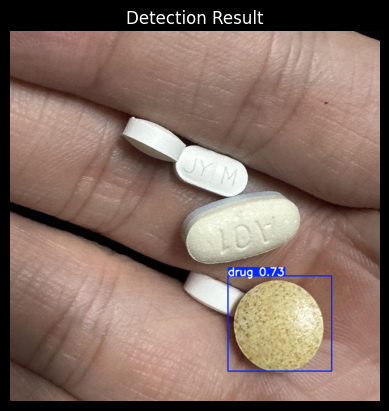

In [21]:
import os
import cv2
import matplotlib.pyplot as plt

# 결과 폴더 경로
output_dir = "C:/project_sep/modeling/YOLO/yolo11n/images/results/predict"

# 결과 폴더 안에 저장된 이미지 파일 리스트
result_files = [
    f for f in os.listdir(output_dir) if f.lower().endswith((".jpg", ".png"))
]

print("탐지된 결과 파일 개수:", len(result_files))
print("첫 5개 파일:", result_files[:5])

# 첫 번째 결과 이미지 시각화
if result_files:
    sample_path = os.path.join(output_dir, result_files[0])
    img = cv2.imread(sample_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detection Result")
    plt.show()

# 결과

테스트가 잘 되지 않았음. 내가 학습시킨 데이터 사진만 인식하고, 실제 이미지 테스트를 진행했을 때 아예 탐지를 못함. 이유가 뭘까?</br>
가설 1. 데이터셋의 다양성 부족